In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc
from scipy import optimize as opt
from collections import defaultdict

SAMPLING_E_ATOL = 2e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 256
MAX_SAMPLES = 32768*4
SAMPLING_CONF_IDX = 2
EXACT_SAMPLES = MAX_SAMPLES*2

CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

Max cost: 6


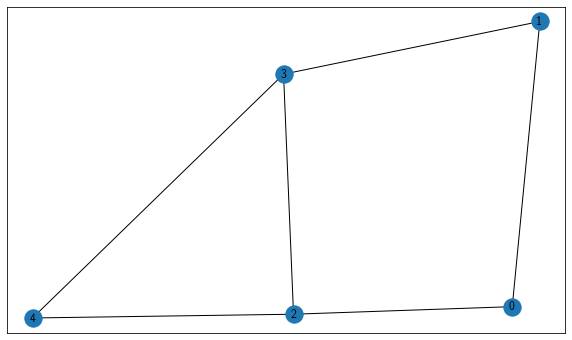

In [2]:
k_cuts=2
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,2.0),(2,3,1.5),(3,1,1.1),(3,4,0.4),(4,2,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,pos=pos)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G, k_cuts)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')

In [4]:
n_iterations = 256
n_conf_idxs = 3

beta_min=-np.pi/4
beta_max=np.pi/4
gamma_min=-np.pi/2
gamma_max=np.pi/2

betas = np.random.uniform(beta_min,beta_max,size=(n_iterations,))
gammas = np.random.uniform(gamma_min,gamma_max,size=(n_iterations,))
Ess = np.zeros((n_conf_idxs,n_iterations))
Ess_exact = np.zeros((n_conf_idxs,n_iterations))
its = range(n_iterations)
conf_idxs = range(1,n_conf_idxs+1)

for c in conf_idxs:
    print('c = %d' % c)
    for i in its:
        circuit = createCircuit_MaxCut(np.array((gammas[i],betas[i])),G,CIRCUIT_DEPTH,k_cuts,CIRCUIT_VERSION)
        E_list,_,_ = sampleUntilPrecision(circuit,backend_sim,None,MIN_SAMPLES,
                                                         MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                         SAMPLING_DELTA_V_RTOL,c, measurementStatistics_MaxCut, measurement_vars={'G' : G, 'k_cuts' : k_cuts})
        Ess[c-1,i] = E_list[-1]
        
        job_sim_exact = execute(circuit, backend_sim, shots=EXACT_SAMPLES)
        [E_exact],_,_ = measurementStatistics_MaxCut(job_sim_exact.result().results, options={'G' : G, 'k_cuts' : k_cuts})
        Ess_exact[c-1,i] = E_exact
        print('%.2f%%' % (100*(i+1)/n_iterations),end='\r')
    print()


c = 1
100.00%
c = 2
100.00%
c = 3
100.00%


<ipython-input-5-7f37c310d70c>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
<ipython-input-5-7f37c310d70c>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis


Text(0.5, 1.0, 'Relative error confidence')

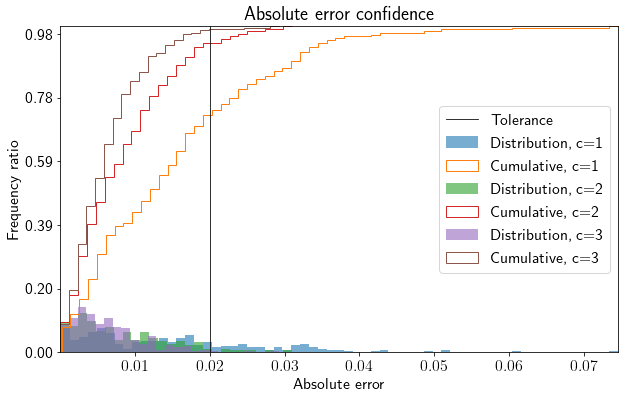

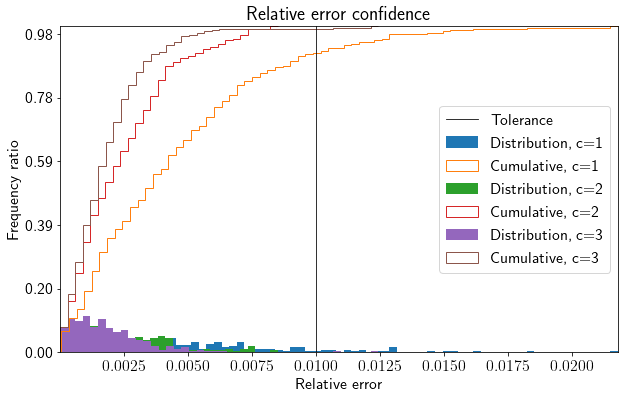

In [5]:
for c in conf_idxs:
    abs_errors = np.array([abs(Ess_exact[c-1,it] - Ess[c-1,it]) for it in its])
    rel_errors = np.array([abs_errors[it]/Ess_exact[c-1,it] for it in its])

    abs_binsize = 0.06*SAMPLING_E_ATOL
    rel_binsize = 0.03*SAMPLING_E_RTOL
    abs_n_bins = int(np.ceil(max(abs_errors)/abs_binsize))
    rel_n_bins = int(np.ceil(max(rel_errors)/rel_binsize))

    abs_bounded_count = np.size(np.where(abs_errors <= SAMPLING_E_ATOL))
    rel_bounded_count = np.size(np.where(rel_errors <= SAMPLING_E_RTOL))
    abs_bounded_pct = int(100*abs_bounded_count/n_iterations)
    rel_bounded_pct = int(100*rel_bounded_count/n_iterations)

    pl.figure(1,figsize=(10,6))
    pl.hist(abs_errors,abs_n_bins,label='Distribution, c=%d' % c,alpha=0.6)
    _,_,patches = pl.hist(abs_errors,abs_n_bins,cumulative=True,histtype='step',
                          label='Cumulative, c=%d' % c)
    patches[0].set_xy(patches[0].get_xy()[:-1]) # Delete last point which is at y=0

    pl.figure(2,figsize=(10,6))
    pl.hist(rel_errors,rel_n_bins,label='Distribution, c=%d' % c)
    _,_,patches = pl.hist(rel_errors,rel_n_bins,cumulative=True,histtype='step',
                          label='Cumulative, c=%d' % c)
    patches[0].set_xy(patches[0].get_xy()[:-1]) # Delete last point which is at y=0
    
pl.figure(1)
pl.axvline(SAMPLING_E_ATOL,linestyle='-',linewidth=0.8,color='k',label='Tolerance')
ax = pl.gca()
yticks = ax.get_yticks()
ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
ax.margins(x=0)
pl.xlabel('Absolute error')
pl.ylabel('Frequency ratio')
pl.ylim(0,n_iterations)
pl.legend(loc='center right')
pl.title('Absolute error confidence')

pl.figure(2)
pl.axvline(SAMPLING_E_RTOL,linestyle='-',linewidth=0.8,color='k',label='Tolerance')
ax = pl.gca()
yticks = ax.get_yticks()
ax.set_yticklabels(['%.2f' % (y/n_iterations) for y in yticks]) # Normalize y-axis
ax.margins(x=0)
pl.xlabel('Relative error')
pl.ylabel('Frequency ratio')
pl.ylim(0,n_iterations)
pl.legend(loc='center right')
pl.title('Relative error confidence')